In [150]:
install.packages("tm")
# remotes::install_github("kiernann/srt")
library(srt)
library(tm)
library(tidyverse)
library(tidytext)

Warning message:
"package 'tm' is in use and will not be installed"


In [151]:
filenames <- list.files(path="./GilmoreGirls",
    pattern="*.srt")

# rename <- (function(x) (strsplit(x, " - ")[[1]][c(1,2,3)]))
# rename <- (function(x) strsplit(x, ".en.srt"))

# filenames <- lapply(filenames, rename)
head(filenames)



[1] "Gilmore Girls - 1x01 - Pilot.en.srt"                             
[2] "Gilmore Girls - 1x02 - The Lorelais' First Day at Chilton.en.srt"
[3] "Gilmore Girls - 1x03 - Kill Me Now.en.srt"                       
[4] "Gilmore Girls - 1x04 - The Deer Hunters.en.srt"                  
[5] "Gilmore Girls - 1x05 - Cinnamon's Wake.en.srt"                   
[6] "Gilmore Girls - 1x06 - Rory's Birthday Parties.en.srt"

In [152]:
prefix = paste(getwd(),"/GilmoreGirls/",sep="")

In [153]:
#Create Meta table
meta = data.frame(matrix(ncol=14,nrow=0))
colnames(meta) = c('n','Episode_Code','Title','Season','Episode','Total_Words','Total_Time',
        'WPM_0th','WPM_25th','WPM_50th','WPM_75th','WPM_100th',
        'WPM_Mean','WPM_Variance')
head(meta)

n,Episode_Code,Title,Season,Episode,Total_Words,Total_Time,WPM_0th,WPM_25th,WPM_50th,WPM_75th,WPM_100th,WPM_Mean,WPM_Variance
<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>


n,start,end,subtitle
<int>,<dbl>,<dbl>,<chr>
1,51.050,53.677,"Please, Luke."
2,53.752,55.514,How many cups have you had this morning?
3,55.586,57.053,- None. - Plus?
4,57.121,59.088,"Five, but yours is better."
5,59.158,61.455,"- You have a problem. - Yes, I do."
6,63.494,65.325,- Junkie. - Angel.


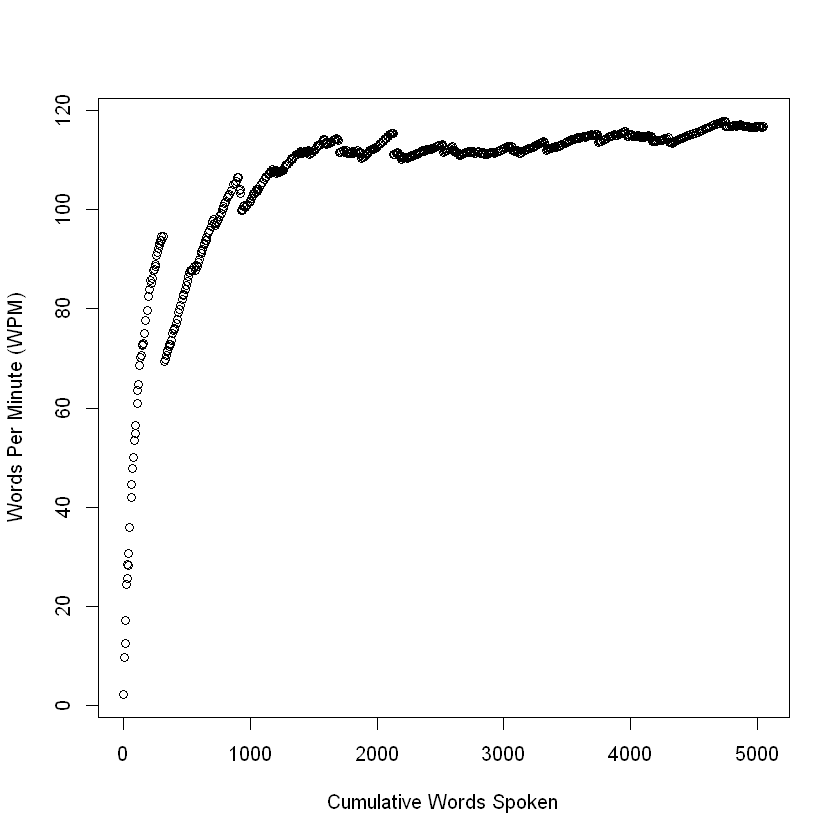

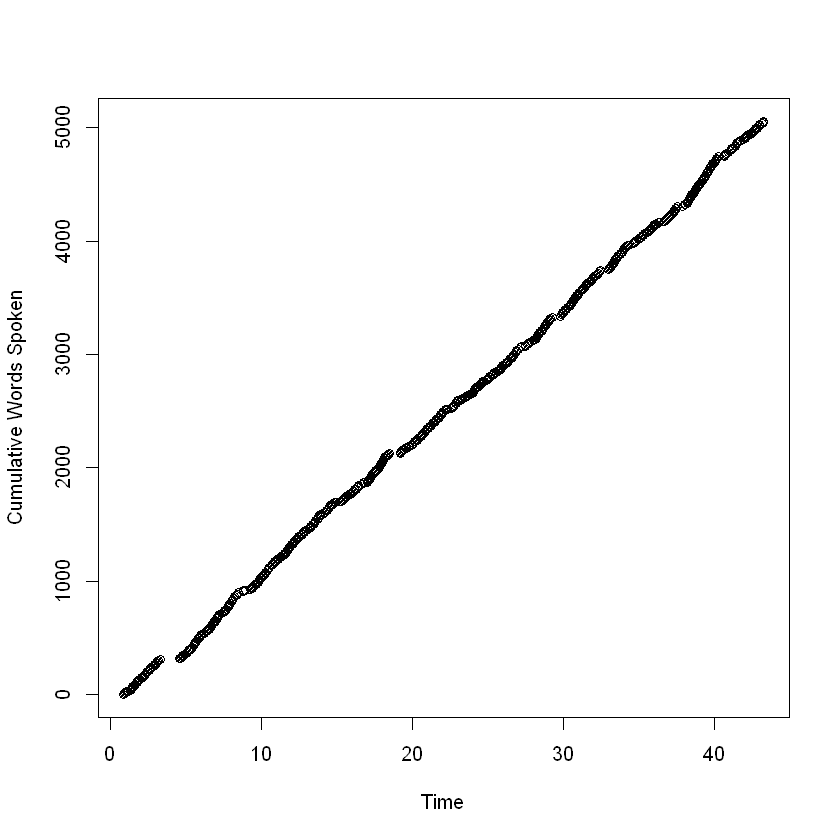

In [154]:
# first item
df = read_srt(paste(prefix,filenames[1],sep=""))
df = df[-nrow(df),]

head(df)

dropPunct <- (function (x) gsub('[[:punct:] ]+',' ',x))
dropNL <- (function(x) gsub("[\n']", "",x))
# countWords <- (function (x) x$cumWords)
dropStopWords <- (function (x) removeWords(x,stopwords('english')))

df = df %>% mutate(subtitle = lapply(subtitle,tolower)) %>%
    mutate(cleanWords = lapply(subtitle,dropNL)) %>%
    mutate(cleanWords = lapply(cleanWords,dropPunct)) %>%
    mutate(end = end/60) %>%
    mutate(cumWordCount = cumsum(sapply(df$subtitle, function(x) length(unlist(strsplit(x, " ")))))) %>%
    mutate(WPM = cumWordCount/(end))


# tail(df)

plot(df$cumWordCount,df$WPM, xlab="Cumulative Words Spoken",ylab="Words Per Minute (WPM)")
plot(df$end,df$cumWordCount, xlab="Time",ylab="Cumulative Words Spoken")

# uniqueWords = unique(df$cleanWords)
# uniqueWords


In [155]:
# quantileData <- quantile(df$WPM,c(0,0.25,0.5,0.75,1))
# quantileData
# sum = summary(df$WPM)
# print(sum)
# print(sum['Min.'])
v = var(df$WPM)
print(v)

# c('Episode','Total_Words','Total_Time','WPM','0th','25th','50th','75th','100th')


[1] 253.1137


In [156]:
for (i in 1:length(filenames)){

    episodeCode = str_extract(filenames[i],"[0-9]+.*?[0-9]+")
    title = str_extract(filenames[i],"(?<=[0-9]\\s-\\s).*(?=\\.en)")
    season = str_extract(filenames[i],"(?<=(\\s-\\s)).*?(?=x)")
    episode = str_extract(filenames[i],"(?<=([0-9]x)).*?(?=\\s)")

    df = read_srt(paste(prefix,filenames[i],sep=""))
    df = df[-nrow(df),]

    dropPunct <- (function (x) gsub('[[:punct:] ]+',' ',x))
    dropNL <- (function(x) gsub("(\n')", "",x))
    # countWords <- (function (x) x$cumWords)
    dropStopWords <- (function (x) removeWords(x,stopwords('english')))

    df = df %>% mutate(subtitle = lapply(subtitle,tolower)) %>%
        mutate(cleanWords = lapply(subtitle,dropNL)) %>%
        mutate(cleanWords = lapply(cleanWords,dropPunct)) %>%
        mutate(end = end/60) %>%
        mutate(cumWordCount = cumsum(sapply(df$subtitle, function(x) length(unlist(strsplit(x, " ")))))) %>%
        mutate(WPM = cumWordCount/(end))


    sum <- array(summary(df$WPM),c(1,6))

    metaRow = data.frame(
        i,episodeCode,title,season,episode,
        as.integer(tail(df,1)$cumWordCount), tail(df,1)$end,
        sum[1],sum[2],sum[3],sum[5],sum[6],sum[4],var(df$WPM)
    )

    colnames(metaRow) = c('n','Episode_Code','Title','Season','Episode','Total_Words','Total_Time',
        'WPM_0th','WPM_25th','WPM_50th','WPM_75th','WPM_100th',
        'WPM_Mean','WPM_Variance')

    meta = rbind(meta,metaRow)
}

In [ ]:
meta['WPM_Total'] = (meta$Total_Words/meta$Total_Time)
head(meta)
# tail(meta)
unique(meta$Season)

In [ ]:
# plot(meta$Total_Words,df$Total_Time, xlab="Total Words In Episode",ylab="Run Time")

# WPM = (meta$Total_Words/meta$Total_Time)
# plot(meta$n,WPM,xlab="Episode Number",ylab="Words Per Minute",main="Gilmore Girls Episodes WPM vs Episode Count")


ggplot(data = meta, aes(x = n, y = WPM_Total, color = Season)) + 
  geom_point() +
  xlab("Episode Number") +
  ylab("Words Per Minute") +
  ggtitle("Gilmore Girls Episodes WPM vs Episode Count")